# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [11]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person', root_dir="/mnt/storage/Datasets/folktables")
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(features, labels, groups, test_size=0.1, random_state=0)


In [5]:
#######
# YOUR CODE
#######
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
#groups
from sklearn.model_selection import cross_val_score

numeric_features = ["AGEP","WKHP", "PWGTP"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train,y_train.values.ravel())

cv = KFold(n_splits=(100))

cv = KFold(n_splits=(100))
score_list = ["accuracy", "f1", "matthews_corrcoef"]
score_dict= {}
for score in score_list: 

    scores = cross_val_score(clf, X_test, y_test.values.ravel(), cv = cv,scoring=score)
    score_dict[score] = scores

<Axes: ylabel='Count'>

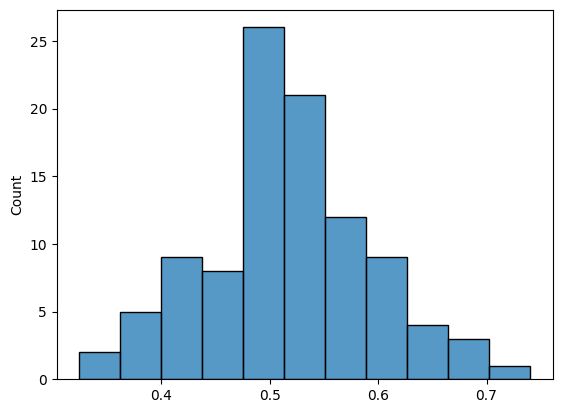

In [6]:
import seaborn as sns

sns.histplot(scores)

In [7]:
scaler = StandardScaler()

features_scaled = scaler.fit_transform(features)

features_p = pd.DataFrame(features_scaled[:,54:], columns = features.columns[54:])

features_np = pd.DataFrame(features_scaled[:,:54], columns = features.columns[:54])

In [8]:
from scipy.linalg import orth

def debias_features(Xs_np, Xs_p):
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np.apply(lambda X: X - X.dot(orthbasis).dot(orthbasis.T))

    # Return debiased nonprotected features
    return Xs_np_debiased

features_np_debiased = debias_features(features_np, features_p)
features_debiased = pd.concat([features_np_debiased, features_p], axis=1)

In [9]:
features_debiased

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,-1.504244,-1.525045,-0.695776,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,4.610708,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
1,1.379906,-2.425334,-0.950025,-1.352836,3.620304,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
2,-0.717658,-0.024564,-0.682394,0.713439,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
3,-1.680683,-1.301046,0.077974,-1.235015,3.438780,-0.096363,-0.38317,-0.163429,-0.302095,-0.261444,...,-0.106427,-0.094215,-0.037545,-0.963585,-0.071533,-0.07375,-0.079782,-0.178291,1.067335,-0.265924
4,-1.110951,0.725677,-1.083841,-1.352836,-0.197754,5.922601,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.527771,-0.774805,-0.013317,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,3.063066,-0.172806,...,-0.115629,-0.111205,-0.025243,1.024056,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
129559,0.679076,-0.025637,0.265316,0.831259,-0.379278,-0.096363,-0.38317,-0.163429,-0.302095,-0.261444,...,-0.106427,-0.094215,-0.037545,-0.963585,10.778907,-0.07375,-0.079782,-0.178291,1.067335,-0.265924
129560,0.331124,-0.024564,-0.789447,0.713439,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,1.024056,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
129561,-0.193267,3.726639,1.137495,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,3.063066,-0.172806,...,8.755036,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924


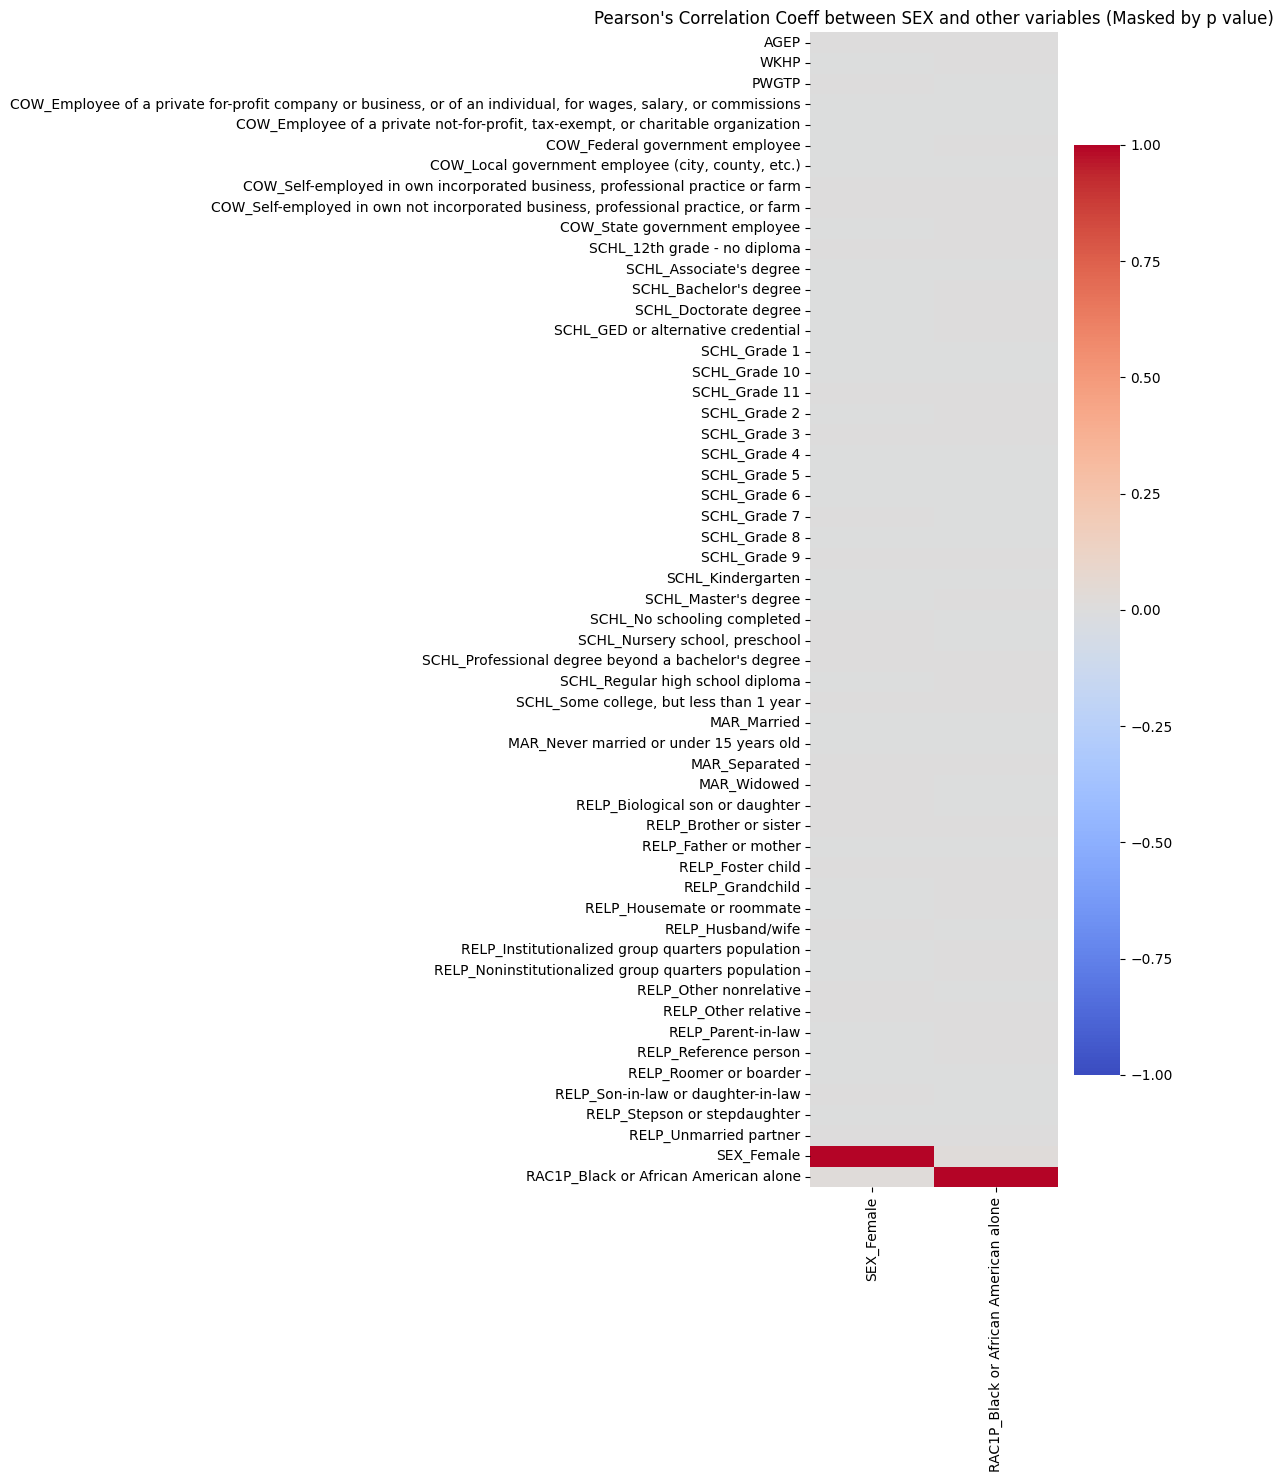

In [12]:
from scipy.stats import pearsonr

# Compute correlation matrix
corr_ = features_debiased.corr()

# Plot correlations with protected features
plt.figure(figsize=(4,15))
sns.heatmap(corr_.iloc[:,54:], cmap="coolwarm", xticklabels=features.columns[54:], yticklabels=features.columns, vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

In [23]:
def fair_debiasing(x_d, x_np, lambd_=0):
    x_fair = x_d + lambd_ * (x_np - x_d)
    return x_fair

feautues_np_debiased_fair = fair_debiasing(features_np_debiased, features_np, lambd_=0)

features_debiased_fair = pd.concat([feautues_np_debiased_fair, features_p], axis=1)
features_debiased_fair

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,-1.504244,-1.525045,-0.695776,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,4.610708,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
1,1.379906,-2.425334,-0.950025,-1.352836,3.620304,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
2,-0.717658,-0.024564,-0.682394,0.713439,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
3,-1.680683,-1.301046,0.077974,-1.235015,3.438780,-0.096363,-0.38317,-0.163429,-0.302095,-0.261444,...,-0.106427,-0.094215,-0.037545,-0.963585,-0.071533,-0.07375,-0.079782,-0.178291,1.067335,-0.265924
4,-1.110951,0.725677,-1.083841,-1.352836,-0.197754,5.922601,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.527771,-0.774805,-0.013317,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,3.063066,-0.172806,...,-0.115629,-0.111205,-0.025243,1.024056,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
129559,0.679076,-0.025637,0.265316,0.831259,-0.379278,-0.096363,-0.38317,-0.163429,-0.302095,-0.261444,...,-0.106427,-0.094215,-0.037545,-0.963585,10.778907,-0.07375,-0.079782,-0.178291,1.067335,-0.265924
129560,0.331124,-0.024564,-0.789447,0.713439,-0.197754,-0.203147,-0.22282,-0.269271,-0.356056,-0.172806,...,-0.115629,-0.111205,-0.025243,1.024056,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924
129561,-0.193267,3.726639,1.137495,-1.352836,-0.197754,-0.203147,-0.22282,-0.269271,3.063066,-0.172806,...,8.755036,-0.111205,-0.025243,-0.976872,-0.106910,-0.10755,-0.070821,-0.201438,-0.936913,-0.265924


In [27]:
features_p

,SEX_Female,RAC1P_Black or African American alone
0,-0.936913,-0.265924
1,-0.936913,-0.265924
2,-0.936913,-0.265924
3,1.067335,-0.265924
4,-0.936913,-0.265924
...,...,...
129558,-0.936913,-0.265924
129559,1.067335,-0.265924
129560,-0.936913,-0.265924
129561,-0.936913,-0.265924


In [36]:
cv = KFold(n_splits=(100))
score_list = ["accuracy", "f1", "matthews_corrcoef"]
score_dict = {k:[] for k in score_list}
lambda_list = []
for i in np.linspace(0, 1, 10):
    lambda_list.append(i)
    log_r = LogisticRegression()
    features_debiased_fair = fair_debiasing(features_np_debiased, features_np, lambd_=i)
    
    X_train_fair, X_test_fair, y_train_fair, y_test_fair, = train_test_split(features_debiased_fair, labels, test_size=0.2, random_state=42)
    clf.fit(X_train_fair, y_train_fair.values.ravel())
    for score in score_list:
        score_dict[score].append(cross_val_score(clf, X_test_fair, y_test_fair.values.ravel(), cv = cv, scoring=score).mean())

In [35]:
score_dict

{'accuracy': [0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948,
  0.7958618948618948],
 'f1': [0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539,
  0.8608228175995539],
 'matthews_corrcoef': [0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795,
  0.502822188209795]}

Text(0.5, 0.98, 'lambda effect on the model performance')

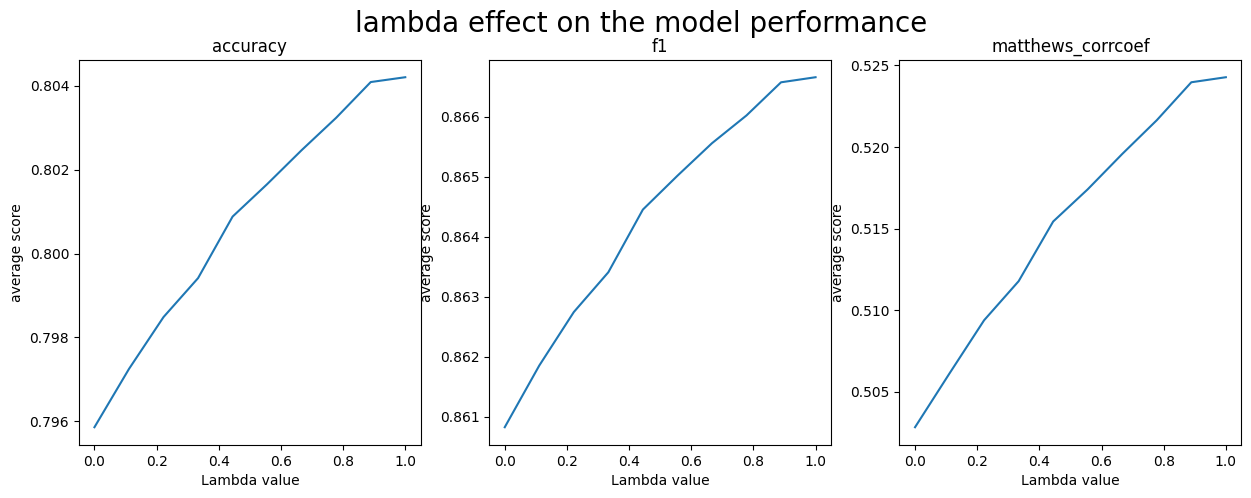

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, score in enumerate(score_list):
    ax[i].plot(lambda_list, score_dict[score])
    ax[i].set_xlabel("Lambda value")
    ax[i].set_ylabel(f"average score")
    ax[i].set_title(score)

plt.suptitle("lambda effect on the model performance", size=20)

In [33]:
features_np_debiased = debias_features(features_np, features_p)
features_np_debiased_fair = fair_debiasing(features_np_debiased, features_np, lambd_=0)
features_debiased_fair = pd.concat([features_np_debiased_fair, features_p], axis=1)

X_train_fair, X_test_fair, y_train_fair, y_test_fair, groups_train, groups_test = train_test_split(features_debiased_fair, labels, groups, test_size=0.2, random_state=42)

In [38]:

score_dict_sex = {}
score_dict_race = {}
score_list = ["accuracy", "f1", "matthews_corrcoef"]
for i in range(1,3):
    score_dict_sex[i] = {}
    score_dict_race[i] = {}
    for score in score_list: 
        print(i)
        score_sex = cross_val_score(clf, X_test_fair.loc[groups_test[groups_test["SEX"] == i].index.tolist()], 
                                    y_test_fair.loc[groups_test[groups_test["SEX"] == i].index.tolist()].values.ravel(), 
                                    cv = cv, scoring = score)
        score_race = cross_val_score(clf, X_test_fair.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()], 
                                    y_test_fair.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()].values.ravel(), 
                                    cv = cv)
        score_dict_sex[i][score] = score_sex
        score_dict_race[i][score] = score_race

1
1
1
2
2
2


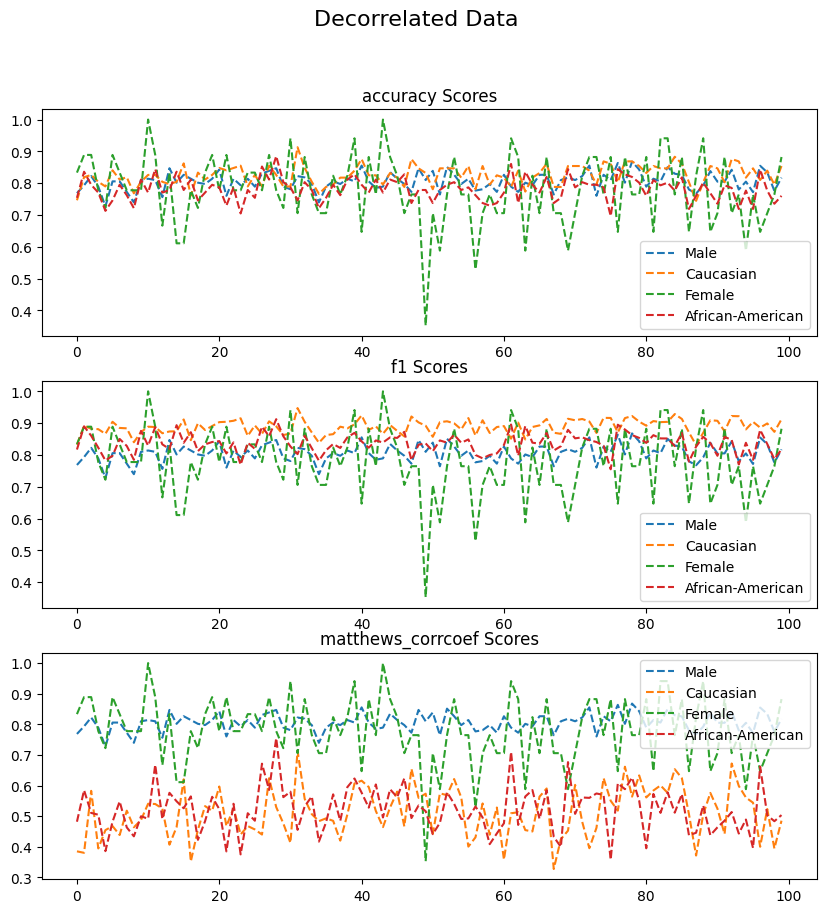

In [40]:

f, axes = plt.subplots(3,1, figsize=(10,10))
                      # # Set a title for the entire figure
f.suptitle("Decorrelated Data", fontsize=16)
for count, metric in enumerate(score_list):
    for i in range(1,3):
        if i == 1: 
            axes[count].plot(score_dict_race[i][metric], linestyle = "--", label = "Male")
            axes[count].plot(score_dict_sex[i][metric], linestyle = "--", label = "Caucasian")
            
        else: 
            axes[count].plot(score_dict_race[i][metric], linestyle = "--", label = "Female")
            axes[count].plot(score_dict_sex[i][metric], linestyle = "--", label = "African-American")
        
        axes[count].set_title(f"{metric} Scores")
        axes[count]
        
        
        
        
        axes[count].legend()

plt.show()

In [47]:
from sklearn.metrics import confusion_matrix





p_f = clf.predict(X_test_fair.loc[groups_test[groups_test["SEX"] == 2].index.tolist()])#, y_test_fair.loc[groups_test[groups_test["SEX"] == 2].index.tolist()])
p_m = clf.predict(X_test_fair.loc[groups_test[groups_test["SEX"] == 1].index.tolist()])#, y_test_fair.loc[groups_test[groups_test["SEX"] == 1].index.tolist()])
p_b = clf.predict(X_test_fair.loc[groups_test[groups_test["RAC1P"] == 2.0].index.tolist()])#, y_test_fair.loc[groups_test[groups_test["RAC1P"] == 2.0].index.tolist()])
p_w = clf.predict(X_test_fair.loc[groups_test[groups_test["RAC1P"] == 1.0].index.tolist()])#, y_test_fair.loc[groups_test[groups_test["RAC1P"] == 1.0].index.tolist()])


confusion_matrix_female = confusion_matrix(p_f, y_test_fair.loc[groups_test[groups_test["SEX"] == 2].index.tolist()])
confusion_matrix_male = confusion_matrix(p_m, y_test_fair.loc[groups_test[groups_test["SEX"] == 1].index.tolist()])
confusion_matrix_blacks = confusion_matrix(p_b, y_test_fair.loc[groups_test[groups_test["RAC1P"] == 2.0].index.tolist()])
confusion_matrix_whites = confusion_matrix(p_w, y_test_fair.loc[groups_test[groups_test["RAC1P"] == 1.0].index.tolist()])

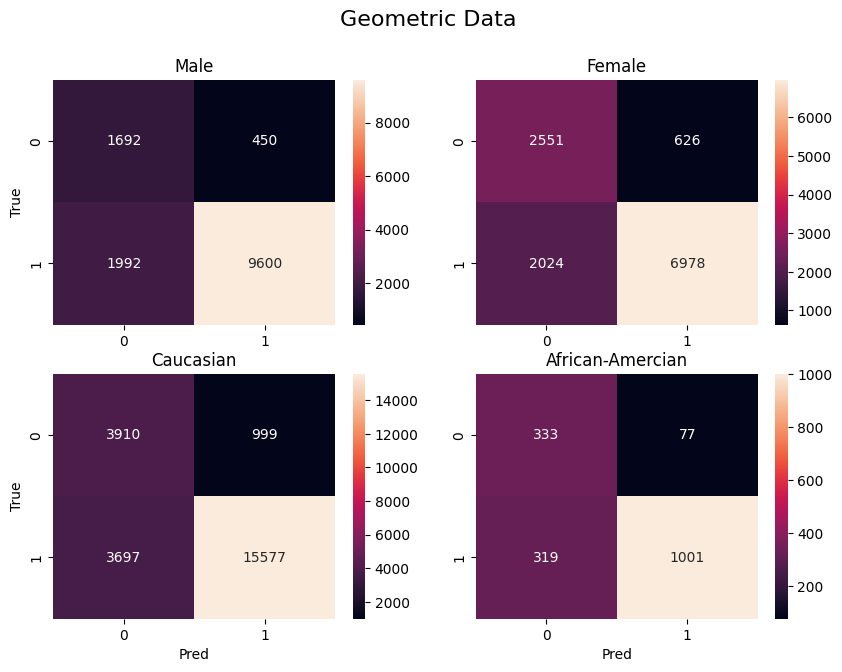

In [49]:

from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

fig, (ax1, ax2) = plt.subplots(2,2, figsize=(10,7))
# Set a title for the entire figure
fig.suptitle("Geometric Data", fontsize=16)
g1= sns.heatmap(confusion_matrix_male, annot=True, fmt='g', ax=ax1[0])
g1.set_ylabel("True")
g1.set_title("Male")
g2= sns.heatmap(confusion_matrix_female, annot=True, fmt='g', ax=ax1[1])
#g1.set_xlabel("True")
g2.set_title("Female")
g3= sns.heatmap(confusion_matrix_whites, annot=True, fmt='g', ax=ax2[0])
g3.set_ylabel("True")
g3.set_xlabel("Pred")
g3.set_title("Caucasian")
g4= sns.heatmap(confusion_matrix_blacks, annot=True, fmt='g', ax=ax2[1])
g4.set_xlabel("Pred")
g4.set_title("African-Amercian")
plt.show()

In [50]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

print("Accuracy_Score Male: ", round(accuracy_score(y_test_fair.loc[groups_test[groups_test["SEX"] == 1].index.tolist()],p_m ),3))
print("Accuracy_Score Female: ", round(accuracy_score(y_test_fair.loc[groups_test[groups_test["SEX"] == 2].index.tolist()],p_f ),3))
print("Accuracy_Score Whites: ", round(accuracy_score(y_test_fair.loc[groups_test[groups_test["RAC1P"] == 1.0].index.tolist()],p_w ),3))
print("Accuracy_Score Blacks: ", round(accuracy_score(y_test_fair.loc[groups_test[groups_test["RAC1P"] == 2.0].index.tolist()],p_b ),3))

print("F1_Score Male: ", round(f1_score(y_test_fair.loc[groups_test[groups_test["SEX"] == 1].index.tolist()],p_m ),3))
print("F1_Score Female: ", round(f1_score(y_test_fair.loc[groups_test[groups_test["SEX"] == 2].index.tolist()],p_f ),3))
print("F1_Score Whites: ", round(f1_score(y_test_fair.loc[groups_test[groups_test["RAC1P"] == 1.0].index.tolist()],p_w ),3))
print("F1_Score Blacks: ", round(f1_score(y_test_fair.loc[groups_test[groups_test["RAC1P"] == 2.0].index.tolist()],p_b ),3))

print("Matthews_corrcoef Male: ", round(matthews_corrcoef(y_test_fair.loc[groups_test[groups_test["SEX"] == 1].index.tolist()],p_m ),5))
print("Matthews_corrcoef Female: ", round(matthews_corrcoef(y_test_fair.loc[groups_test[groups_test["SEX"] == 2].index.tolist()],p_f ),5))
print("Matthews_corrcoef Whites: ", round(matthews_corrcoef(y_test_fair.loc[groups_test[groups_test["RAC1P"] == 1.0].index.tolist()],p_w ),5))
print("Matthews_corrcoef Blacks: ", round(matthews_corrcoef(y_test_fair.loc[groups_test[groups_test["RAC1P"] == 2.0].index.tolist()],p_b ),5))

Accuracy_Score Male:  0.822
Accuracy_Score Female:  0.782
Accuracy_Score Whites:  0.806
Accuracy_Score Blacks:  0.771
F1_Score Male:  0.887
F1_Score Female:  0.84
F1_Score Whites:  0.869
F1_Score Blacks:  0.835
Matthews_corrcoef Male:  0.50616
Matthews_corrcoef Female:  0.52418
Matthews_corrcoef Whites:  0.5238
Matthews_corrcoef Blacks:  0.50064
